In [1]:
import pandas as pd
import os
os.chdir('../')
from python_code import gaussian_processes_functions as gp
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('../data/utilities.csv')
df = df.sort_values('temp')

In [3]:
x = df['temp'].to_numpy()
y =  (df['gasbill']/df['billingdays']).to_numpy()
x_plot = np.linspace(x.min(), x.max(), 100)

In [4]:
y_pred, _ = gp.get_GP_parameters(x, y, x_plot, sigma_squared=1, tau_1=.01, tau_2=1e-6, b=10) 

In [5]:
draws_at_points = gp.draw_GP(x, y, x, sigma_squared=1, tau_1=.01, tau_2=1e-6, b=10, n_predictions=1000) 

In [6]:
CI = np.quantile(draws_at_points, [0.025, 0.975], axis=0)

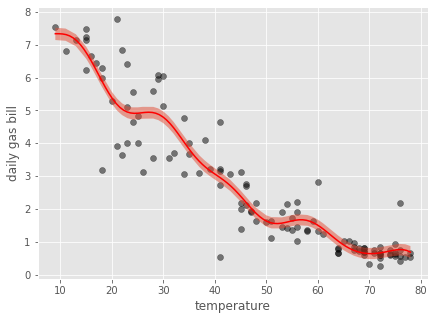

In [7]:
plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha =.5, color='black')
plt.fill_between(x, CI[0, :], CI[1, :], alpha=.5)
plt.plot(x_plot, y_pred, color='red')
plt.ylabel('daily gas bill')
plt.xlabel('temperature');

In [13]:
from scipy.stats import multivariate_normal
def calculate_maginal_P(x, tau_1, b, sigma_squared, tau_2=0):
    cov_fun = gp.calculate_matern_covariance_function(x, b, tau_1, tau_2)
    cov_norm = sigma_squared*np.eye(x.shape[0]) + cov_fun
    dist = multivariate_normal(cov=cov_norm, allow_singular=True)
    return dist

In [18]:
tau_1_range = np.linspace(20, 80, 50)
b_range = np.linspace(20, 80, 50)
tt, bb = np.meshgrid(tau_1_range, b_range)
all_tau = tt.flatten()
all_b = bb.flatten()

In [19]:
all_marginals = []
for n in range(len(all_b)):
    dist = calculate_maginal_P(x.reshape(-1,1), all_tau[n], all_b[n], sigma_squared=.6, tau_2=0)
    marginal = dist.logpdf(y)
    all_marginals.append(marginal)


In [26]:
best_comb = np.argwhere(np.array(all_marginals) == np.max(all_marginals))

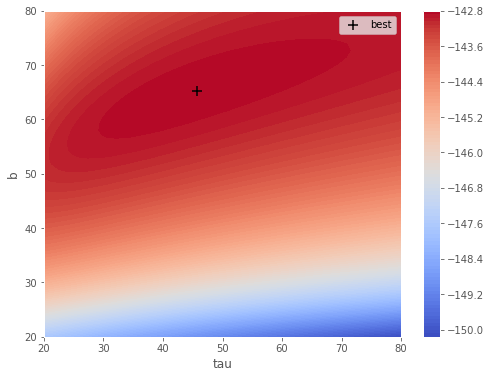

In [34]:
plt.figure(figsize=(8, 6))
plt.contourf(tt, bb, np.array(all_marginals).reshape(50,50), 100, cmap='coolwarm')
plt.colorbar()
plt.scatter(all_tau[best_comb], all_b[best_comb], color='black', marker='+', label='best', s=100)
plt.xlabel('tau')
plt.ylabel('b')
plt.legend()
